In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl
from openpyxl import load_workbook
import os
#from ccfj import GetStationPairs
from geopy.distance import great_circle
#import shapefile
import geopandas as gp
import yaml
import math

from scipy.spatial import ConvexHull
from scipy.interpolate import griddata
from shapely.geometry import Point, Polygon

from pykrige.ok import OrdinaryKriging
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [21]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import plotlib

In [22]:
flag_project = 1 # 0--regular; 1--repartrition

In [23]:
if flag_project == 0:
    file_project = 'a-project.yml'
elif flag_project == 1:
    file_project = 'a-project_repar.yml'
elif flag_project == 2:
    file_project = 'a-project_voro.yml'
    
with open(file_project, 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']

#name_project = 'project/output_FJSJ_16-01/'               
#name_project = 'project_repartrition/repartrition_01-03/'               
#name_project = 'project_voronoi/voronoi_01-03/'         

In [24]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v4.0/output_repar_v9.2_01-01/


In [25]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [26]:
dir_model_fund = dir_project + info_basic['dir_model_fund']
dir_model = dir_project + info_basic['dir_model']
dir_image = dir_project + info_basic['dir_image']+'Vs_compare/'
if not os.path.exists(dir_image):
    os.makedirs(dir_image)
dir_inv_dispernet = dir_project + info_basic['dir_inv_dispernet']
dir_partition = dir_project + info_basic['dir_partition']
key_subworks = info_basic['key_subworks']
M = len(key_subworks)
key_subworks

['1--08-03',
 '2--09-03',
 '3--10-03',
 '4--11-03',
 '5--12-03',
 '6--13-03',
 '7--14-03',
 '8--15-03',
 '9--16-03',
 '10--18-03',
 '12--20-03',
 '13--21-03',
 '15--23-03',
 '17--25-03',
 '18--26-03',
 '19--27-03',
 '20--28-03',
 '21--29-03',
 '22--30-03',
 '23--31-03',
 '25--33-03',
 '26--34-03',
 '28--36-03',
 '30--41-03',
 '31--42-03',
 '33--46-03',
 '34--47-03',
 '35--48-03',
 '36--52-03',
 '37--53-03',
 '38--07-04',
 '39--08-04',
 '40--09-04',
 '41--10-04',
 '42--12-04',
 '43--13-04',
 '44--17-04',
 '45--20-04',
 '46--21-04',
 '48--23-04',
 '49--24-04',
 '50--25-04',
 '51--27-04',
 '52--28-04',
 '53--29-04',
 '54--30-04',
 '55--31-04',
 '56--32-04',
 '57--33-04',
 '58--34-04',
 '59--35-04',
 '60--36-04',
 '63--47-04',
 '65--49-04',
 '66--52-04',
 '67--53-04',
 '68--08-05',
 '69--12-05',
 '70--13-05',
 '71--14-05',
 '72--16-05',
 '75--22-05',
 '76--24-05',
 '77--26-05',
 '78--27-05',
 '79--28-05',
 '80--29-05',
 '81--30-05',
 '84--35-05',
 '85--36-05',
 '86--37-05',
 '88--39-05',
 

In [27]:
def GetStationPairs(nsta):
    StationPair = []
    for ii in range(nsta):
        for jj in range(ii+1,nsta):
            StationPair.append(ii)
            StationPair.append(jj)
    StationPair = np.array(StationPair,dtype=np.int32)
    return StationPair

In [28]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist() 
lat_stations_all =  stainfo['latitude'].tolist() 
lon_stations_all =  stainfo['longitude'].tolist() 
elevation_stations_all = stainfo['elevation'].tolist()

In [29]:
stations_partition = {}
lat_stations_partition = {}
lon_stations_partition = {}
lat_centroid_partition = []
lon_centroid_partition = []
num_stations = []
for key in key_subworks:
    filepath = dir_partition + str(key) + '.txt'
    stations_this, lat_stations_this, lon_stations_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_partition[key] = stations_this
    lat_stations_partition[key] = lat_stations_this.astype(float)
    lon_stations_partition[key] = lon_stations_this.astype(float)
    num_stations.append(len(stations_this))
    lat_centroid_partition.append(np.mean(lat_stations_this.astype(float)))
    lon_centroid_partition.append(np.mean(lon_stations_this.astype(float)))

In [34]:
#points = np.column_stack((lon_stations_all, lat_stations_all))
points = np.column_stack((lon_centroid_partition, lat_centroid_partition))
hull = ConvexHull(points)
polygon = Polygon(points[hull.vertices])
index_sta = []
lon_stations_in = []
lat_stations_in = []
elevation_stations_in = []
for i in range(len(lon_stations_all)):
    if polygon.contains(Point(lon_stations_all[i], lat_stations_all[i])):
        index_sta.append(i)
        lon_stations_in.append(lon_stations_all[i])
        lat_stations_in.append(lat_stations_all[i])
        elevation_stations_in.append(elevation_stations_all[i])

In [35]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

In [36]:
inter_file = dir_inv_dispernet + 'vs_inter.npz'
inter = np.load(inter_file, allow_pickle=True)

In [37]:
vs_fund = inter['vs_fund']
vs = inter['vs']
lon_inter_in = inter['lon']
lat_inter_in = inter['lat']
z = inter['depth']
dz = inter['dz']
N = inter['N']

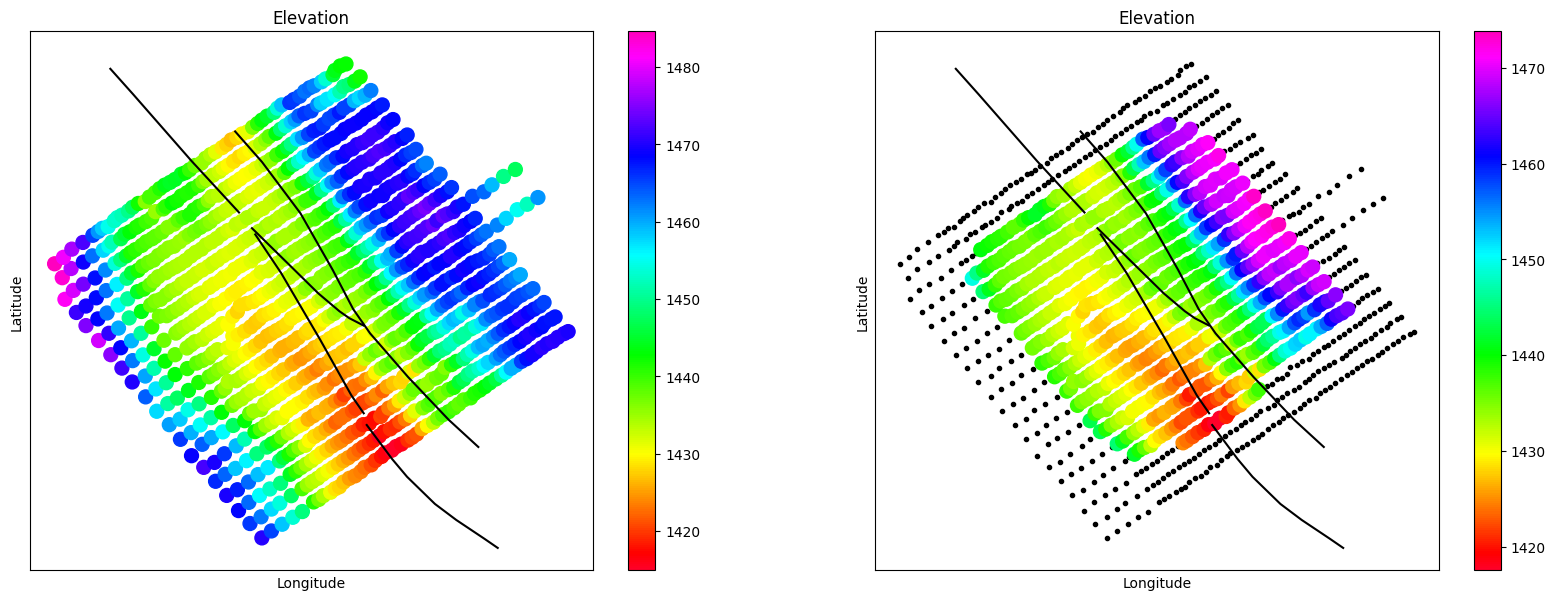

In [38]:
fig = plt.figure(figsize=(20, 7))
ax  = fig.add_subplot(121)
ax.scatter(lon_stations_all, lat_stations_all,marker='.',color='k')
ax.set_xticks([])  #去掉横坐标值
ax.set_yticks([])  #去掉纵坐标值
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Elevation')
flag_add = 0.0005
ax.set_xlim([min(lon_stations_all)-flag_add, max(lon_stations_all)+flag_add])
ax.set_ylim([min(lat_stations_all)-flag_add, max(lat_stations_all)+flag_add])
for j in range(len(faults)):
    ax.plot(faults['clark'+str(j+1)]['lon'], faults['clark'+str(j+1)]['lat'], 'k')
im = ax.scatter(lon_stations_all,lat_stations_all,c=elevation_stations_all,cmap='gist_rainbow',s=100)
plt.colorbar(im)

ax  = fig.add_subplot(122)
ax.scatter(lon_stations_all, lat_stations_all,marker='.',color='k')
ax.set_xticks([])  #去掉横坐标值
ax.set_yticks([])  #去掉纵坐标值
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Elevation')
flag_add = 0.0005
ax.set_xlim([min(lon_stations_all)-flag_add, max(lon_stations_all)+flag_add])
ax.set_ylim([min(lat_stations_all)-flag_add, max(lat_stations_all)+flag_add])
for j in range(len(faults)):
    ax.plot(faults['clark'+str(j+1)]['lon'], faults['clark'+str(j+1)]['lat'], 'k')
im = ax.scatter(lon_stations_in,lat_stations_in,c=elevation_stations_in,cmap='gist_rainbow',s=100)
plt.colorbar(im)

### Do clipper

In [39]:
# define traces
traces = {}
for i in range(4,18):
    traces[i] = np.zeros([2,2])
    sta_start = 'R'+'20'+str(i).zfill(2)
    sta_end = 'R'+'30'+str(i).zfill(2)
    if sta_start not in stalist_all:
        print('Warning: start station %s not found' % sta_start)
    if sta_end not in stalist_all:
        print('Warning: end station %s not found' % sta_end)
    traces[i][0,0] = lon_stations_all[stalist_all.index(sta_start)]
    traces[i][0,1] = lat_stations_all[stalist_all.index(sta_start)]
    traces[i][1,0] = lon_stations_all[stalist_all.index(sta_end)]
    traces[i][1,1] = lat_stations_all[stalist_all.index(sta_end)]

In [40]:
def extract_points(tag_trace,lon_inter_in,lat_inter_in):
    global traces
    trace = traces[tag_trace]

    x1 = trace[0,0]
    y1 = trace[0,1]
    x2 = trace[1,0]
    y2 = trace[1,1]
    A = (y2-y1)/(x2-x1)
    B = -1
    C = y2 - A*x2

    flag_r = np.sqrt(( (lon_inter_in[1]-lon_inter_in[0])**2 + (lat_inter_in[1]-lat_inter_in[0])**2 ))/2
    index = []
    
    for i in range(len(lon_inter_in)):
        x0 = lon_inter_in[i]
        y0 = lat_inter_in[i]
        d = abs(A*x0+B*y0+C)/math.sqrt(A**2+B**2)
        if d <= flag_r:
            index.append(i)
    return index

In [41]:
def find_intersection_point(point1_line, point2_line, external_point):
    # 计算直线的斜率
    line_slope = (point2_line[1] - point1_line[1]) / (point2_line[0] - point1_line[0])

    # 计算直线的截距
    line_intercept = point1_line[1] - line_slope * point1_line[0]

    # 计算垂线的斜率
    perpendicular_slope = -1 / line_slope

    # 计算垂线的截距
    perpendicular_intercept = external_point[1] - perpendicular_slope * external_point[0]

    # 求解方程组以找到交点
    intersection_x = (perpendicular_intercept - line_intercept) / (line_slope - perpendicular_slope)
    intersection_y = line_slope * intersection_x + line_intercept

    return intersection_x, intersection_y

In [47]:
lon_inter_verti = {}
lat_inter_verti = {}
vs_inter_verti = {}
vs_inter_fund_verti = {}   
lon_ele_verti = {}
lat_ele_verti = {} 
ele_verti = {}
r = {}
r_ele = {}
indexes = {}
indexes_ele = {}
loc_starts = {}
loc_ele_starts = {}
for tag in traces.keys():
    index = extract_points(tag,lon_inter_in,lat_inter_in)
    indexes[tag] = index
    index_ele = extract_points(tag,lon_stations_in,lat_stations_in)
    indexes_ele[tag] = index_ele
    lon_inter_verti[tag] = np.array(lon_inter_in)[index]
    lat_inter_verti[tag] = np.array(lat_inter_in)[index]
    lon_ele_verti[tag] = np.array(lon_stations_in)[index_ele]
    lat_ele_verti[tag] = np.array(lat_stations_in)[index_ele]
    r[tag] = np.zeros(len(index))
    r[tag][0] = 0
    r_ele[tag] = np.zeros(len(index_ele))
    r_ele[tag][0] = 0
    vs_inter_verti[tag] = []
    vs_inter_fund_verti[tag] = []
    ele_verti[tag] = []
    loc_start = find_intersection_point(traces[tag][0], traces[tag][1], [lon_inter_verti[tag][0], lat_inter_verti[tag][0]])
    loc_ele_start = find_intersection_point(traces[tag][0], traces[tag][1], [lon_inter_verti[tag][0], lat_inter_verti[tag][0]])
    loc_starts[tag] = loc_start
    loc_ele_starts[tag] = loc_ele_start
    for i in range(N):
        vs_inter_verti[tag].append(vs[i,index])
        vs_inter_fund_verti[tag].append(vs_fund[i,index])
    ele_verti[tag].append(np.array(elevation_stations_in)[index_ele])
    for i in range(len(index)):
        if i > 0:
            loc_new = find_intersection_point(traces[tag][0], traces[tag][1], [lon_inter_verti[tag][i], lat_inter_verti[tag][i]])
            r[tag][i] = np.sqrt((loc_new[0]-loc_start[0])**2 + (loc_new[1]-loc_start[1])**2)
    for i in range(len(index_ele)):
        if i > 0:
            loc_new = find_intersection_point(traces[tag][0], traces[tag][1], [lon_ele_verti[tag][i], lat_ele_verti[tag][i]])
            r_ele[tag][i] = np.sqrt((loc_new[0]-loc_ele_start[0])**2 + (loc_new[1]-loc_ele_start[1])**2)

In [48]:
# 判断两条线段是否相交
def cross_product(p1, p2, p3):
    """计算叉积"""
    return (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p2[1] - p1[1]) * (p3[0] - p1[0])

def on_segment(p1, p2, p3):
    """检查p2是否在以p1和p3为端点的线段上"""
    return min(p1[0], p3[0]) <= p2[0] <= max(p1[0], p3[0]) and min(p1[1], p3[1]) <= p2[1] <= max(p1[1], p3[1])

def segments_intersect(p1, q1, p2, q2):
    """检查由(p1, q1)和(p2, q2)形成的两条线段是否相交"""
    # 检查线段的方向
    o1 = cross_product(p1, q1, p2)
    o2 = cross_product(p1, q1, q2)
    o3 = cross_product(p2, q2, p1)
    o4 = cross_product(p2, q2, q1)

    # 如果两条线段的方向相异，则它们相交
    if o1 * o2 < 0 and o3 * o4 < 0:
        return True
    # 特殊情况处理
    if o1 == 0 and on_segment(p1, p2, q1):
        return True
    if o2 == 0 and on_segment(p1, q2, q1):
        return True
    if o3 == 0 and on_segment(p2, p1, q2):
        return True
    if o4 == 0 and on_segment(p2, q1, q2):
        return True

    return False

def plot_segments(p1, q1, p2, q2):
    plt.plot([p1[0], q1[0]], [p1[1], q1[1]], color='blue', label='Segment 1')
    plt.plot([p2[0], q2[0]], [p2[1], q2[1]], color='red', label='Segment 2')

    intersection = segments_intersect(p1, q1, p2, q2)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Segments Intersection')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

In [49]:
def find_fault_inter(tag_trace):
    global traces
    global faults
    global lon_inter_verti
    global lat_inter_verti

    lat_fault_inter = []
    lon_fault_inter = []

    for key in faults.keys():
        lon_fault = faults[key]['lon']
        lat_fault = faults[key]['lat']  
        index_fault_start = np.argmin(lon_fault)
        index_fault_end = np.argmax(lon_fault)
        p1 = [lon_fault[index_fault_start], lat_fault[index_fault_start]]
        q1 = [lon_fault[index_fault_end], lat_fault[index_fault_end]]
        index_trace_start = np.argmin(lon_inter_verti[tag_trace])
        index_trace_end = np.argmax(lon_inter_verti[tag_trace])
        p2 = [lon_inter_verti[tag_trace][index_trace_start], lat_inter_verti[tag_trace][index_trace_start]]
        q2 = [lon_inter_verti[tag_trace][index_trace_end], lat_inter_verti[tag_trace][index_trace_end]]
        
        if segments_intersect(p1, q1, p2, q2):
            # find the nearest fault point
            lon_trace = lon_inter_verti[tag_trace]
            lat_trace = lat_inter_verti[tag_trace]

            min_distance = float('inf')

            for lon1, lat1 in zip(lon_fault, lat_fault):
                for lon2, lat2 in zip(lon_trace, lat_trace):
                    distance = math.sqrt((lon1 - lon2)**2 + (lat1 - lat2)**2)
                    if distance < min_distance:
                        min_distance = distance
                        lon_fault_near = lon1
                        lat_fault_near = lat1
                        lon_trace_near = lon2
                        lat_trace_near = lat2
                    
            lon_fault_inter.append( lon_trace_near )
            lat_fault_inter.append( lat_trace_near )
        
        """
        intersection = find_lines_inter(p1, q1, p2, q2)
        if intersection is not None:
            lon_fault_inter.append(intersection[0])
            lat_fault_inter.append(intersection[1])
        """
    return lon_fault_inter, lat_fault_inter

In [50]:
def find_fault_inter1(tag_trace):
    global traces
    global faults
    global lon_inter_verti
    global lat_inter_verti

    lat_fault_inter = []
    lon_fault_inter = []
    lon_ref_fault = []
    lat_ref_fault = []

    for key in faults.keys():
        lon_fault = faults[key]['lon']
        lat_fault = faults[key]['lat']  
        index_fault_start = np.argmin(lon_fault)
        index_fault_end = np.argmax(lon_fault)
        p1 = [lon_fault[index_fault_start], lat_fault[index_fault_start]]
        q1 = [lon_fault[index_fault_end], lat_fault[index_fault_end]]
        index_trace_start = np.argmin(lon_inter_verti[tag_trace])
        index_trace_end = np.argmax(lon_inter_verti[tag_trace])
        p2 = [lon_inter_verti[tag_trace][index_trace_start], lat_inter_verti[tag_trace][index_trace_start]]
        q2 = [lon_inter_verti[tag_trace][index_trace_end], lat_inter_verti[tag_trace][index_trace_end]]
        
        if segments_intersect(p1, q1, p2, q2):
            # find the nearest fault point
            lon_trace = lon_inter_verti[tag_trace]
            lat_trace = lat_inter_verti[tag_trace]
            r_trace = []
            for i in range(len(lon_fault)):
                r_trace.append( np.sum(np.sqrt((np.array(lon_trace)-lon_fault[i])**2 + (np.array(lat_trace)-lat_fault[i])**2)) )
            lon_ref_fault.append( lon_fault[np.argmin(r_trace)] )
            lat_ref_fault.append( lat_fault[np.argmin(r_trace)] )
            # find the nearst trace point
            r_fault = np.sqrt((np.array(lon_trace)-lon_ref_fault[0])**2 + (np.array(lat_trace)-lat_ref_fault[0])**2)
            lon_fault_inter.append( lon_trace[np.argmin(r_fault)] )
            lat_fault_inter.append( lat_trace[np.argmin(r_fault)] )
        
        """
        intersection = find_lines_inter(p1, q1, p2, q2)
        if intersection is not None:
            lon_fault_inter.append(intersection[0])
            lat_fault_inter.append(intersection[1])
        """
    return lon_fault_inter, lat_fault_inter,lon_ref_fault,lat_ref_fault

In [54]:
v_min = 0.45
v_max = 1.15
#v_min = 0.3
#v_max = 0.9

In [56]:
for i in list(traces.keys()):
    print('Plotting trace %d' % i)
    fig = plt.figure(figsize=(20, 10))

    ax1 = plt.subplot2grid((18,3),(2,0),colspan=2,rowspan=7)
    im = ax1.imshow(vs_inter_fund_verti[i], aspect='auto', cmap='gist_rainbow', extent=[0,max(r[i]),N*dz,0], vmin=v_min, vmax=v_max)
    ax1.set_xticks([])  #去掉横坐标值
    #ax1.set_xlabel('Offset')
    ax1.set_ylabel('Depth /m Fundamental')
    #plt.colorbar(im)
    # 找到断层点
    lon_fault_inter, lat_fault_inter = find_fault_inter(i)
    #lon_fault_inter, lat_fault_inter, lon_ref_fault, lat_ref_fault = find_fault_inter(i)
    r_fault = []
    for j in range(len(lon_fault_inter)):
        r_fault.append(np.sqrt((loc_starts[i][0]-lon_fault_inter[j])**2 + (loc_starts[i][1]-lat_fault_inter[j])**2))
        #ax3.scatter(r_fault[j],0, c='k', s=50)
        ax1.vlines(r_fault[j], 0, N/10*dz, colors = "k", linestyles = "dashed")
    ax1.set_title('Fundamental')
    plt.colorbar(im,orientation='horizontal',aspect=100,fraction=0.05,pad=0.05)


    ax2 = plt.subplot2grid((18,3),(10,0),colspan=2,rowspan=8)
    im = ax2.imshow(vs_inter_verti[i], aspect='auto', cmap='gist_rainbow', extent=[0,max(r[i]),N*dz,0], vmin=v_min, vmax=v_max)
    #ax3.set_xticks([])  #去掉横坐标值
    ax2.set_xlabel('Offset')
    ax2.set_ylabel('Depth /m Overtones')
    # 找到断层点
    #lon_fault_inter, lat_fault_inter = find_fault_inter(i)
    for j in range(len(lon_fault_inter)):
        r_fault.append(np.sqrt((loc_starts[i][0]-lon_fault_inter[j])**2 + (loc_starts[i][1]-lat_fault_inter[j])**2))
        #ax3.scatter(r_fault[j],0, c='k', s=50)
        ax2.vlines(r_fault[j], 0, N/10*dz, colors = "k", linestyles = "dashed")
    ax2.set_title('Overtones')
    


    axele = plt.subplot2grid((18,3),(0,0),colspan=2,rowspan=1)
    axele.set_xticks([])  #去掉横坐标值
    #axele.set_yticks([])  #去掉纵坐标值
    axele.set_ylabel('Elev')
    axele.spines['top'].set_visible(False)
    

    # 画ele的柱状图
    #axele.bar(r_ele[i], ele_verti[i][0]-min(ele_verti[i][0]), width=0.1, color='g')
    index_r = np.argsort(r_ele[i])
    axele.plot(r_ele[i][index_r], ele_verti[i][0][index_r]-min(ele_verti[i][0]), color='k')
    axele.fill_between(r_ele[i][index_r], 0, ele_verti[i][0][index_r]-min(ele_verti[i][0]), color='k', alpha=0.5)
    for j in range(len(lon_fault_inter)):
        r_fault.append(np.sqrt((loc_starts[i][0]-lon_fault_inter[j])**2 + (loc_starts[i][1]-lat_fault_inter[j])**2))
        #ax1.scatter(r_fault[j],0, c='k', s=50)
        axele.vlines(r_fault[j], 0, max(ele_verti[i][0][index_r]-min(ele_verti[i][0])), colors = "k", linestyles = "dashed")
    axele.set_xlim([0, max(r[i])])

    ax3 = plt.subplot2grid((2,3),(0,2),colspan=1,rowspan=1)
    ax3.scatter(lon_stations_all, lat_stations_all, c='k', s=0.08)
    for j in range(len(faults)):
        ax3.plot(faults['clark'+str(j+1)]['lon'], faults['clark'+str(j+1)]['lat'], 'k')
    ax3.scatter(lon_inter_in, lat_inter_in, c='b', s=0.1)
    ax3.scatter(np.array(lon_inter_in)[indexes[i]], np.array(lat_inter_in)[indexes[i]], c='r', s=0.3)
    ax3.scatter(lon_fault_inter, lat_fault_inter, c='y', s=50)

    ax3.set_xticks([])  #去掉横坐标值
    ax3.set_yticks([])  #去掉纵坐标值
    ax3.set_xlabel('Longitude')
    ax3.set_ylabel('Latitude')
    #for j in range(len(lon_ref_fault)):
    #    ax3.scatter(lon_ref_fault[j],lat_ref_fault[j],s = 50)


    ax4 = plt.subplot2grid((2,3),(1,2),colspan=1,rowspan=1)
    ax4.scatter(lon_stations_all, lat_stations_all,marker='.',color='k',s=0.08)
    ax4.set_xticks([])  #去掉横坐标值
    ax4.set_yticks([])  #去掉纵坐标值
    ax4.set_xlabel('Longitude')
    ax4.set_ylabel('Latitude')
    ax4.set_title('Elevation')
    flag_add = 0.0005
    ax4.set_xlim([min(lon_stations_all)-flag_add, max(lon_stations_all)+flag_add])
    ax4.set_ylim([min(lat_stations_all)-flag_add, max(lat_stations_all)+flag_add])
    for j in range(len(faults)):
        ax4.plot(faults['clark'+str(j+1)]['lon'], faults['clark'+str(j+1)]['lat'], 'k')
    im = ax4.scatter(lon_stations_in,lat_stations_in,c=elevation_stations_in,cmap='gist_rainbow',s=20)
    ax4.plot(np.array(lon_inter_in)[indexes[i]], np.array(lat_inter_in)[indexes[i]], c='k')
    #plt.colorbar(im, ax=ax4, location='top', shrink=0.6)
 
    cax = inset_axes(ax4,
                 width="1%",  # colorbar宽度占主轴宽度的百分比
                 height="50%",  # colorbar高度占主轴高度的百分比
                 loc='upper right')  # 在右上角放置colorbar
    cbar = plt.colorbar(im, cax=cax, orientation='vertical')
    #plt.tight_layout()
    plt.savefig(dir_image+'Vs_verticle_trace_'+str(i)+'.png')
    #plt.savefig(dir_image+'Vs_shallow_verticle_trace_'+str(i)+'.png')
    plt.close()

Plotting trace 4
